## Aprendizaje no supervisado: Clustering - Version 2

#### Marcelo Cena

### Objetivos

En este practico se explorar ́an diferentes soluciones de clustering, para desarrollar las capacidades de analisis de
soluciones de clustering. Es preferible que los conjuntos de datos con los que trabajar sean propios, ya que de esta forma podran aplicar su conocimiento del dominio en la interpretacion de las diferentes soluciones. Alternativamente, pueden usar conjuntos de datos de los ejemplos de la materia.

En los mismos, hacer una breve discusion del problema y explicar como puede ser  ́util usar tecnicas de clustering.

In [1]:
from sklearn.datasets import load_files 

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

from __future__ import print_function

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from sklearn.cluster import KMeans

# Dataset

Usaremos un dataset extraido de https://labrosa.ee.columbia.edu/millionsong/ que consiste en datos de canciones extraidos de diferentes sitios y el rating que los usuarios le dan a las mismas.
Este dataset contiene dos archivos, uno guardado en formato csv, contiene metadatos de cada canción, como id, título, disco, artista y año, de los cuales vamos a utilizar solamente los datos correspondientes a los titulos y disco para intentar hacer un clustering de las canciones en relación a las palabras en común.
Como en la version anterior conseguimos un gran cluster con muchas canciones y todos los otros con no mas de 500, vamos a probar concatenando el nombre de la cancion con el nombre del disco .

In [2]:
canciones = pd.read_csv('data/song_data.csv')
#display(canciones.head(2))
canciones_df = pd.read_table('data/Songs_10000.txt',header=None)
canciones_df.columns = ['user_id', 'song_id', 'listen_count']
#display(canciones_df.head(2))
song_df1 = pd.merge(canciones_df, canciones.drop_duplicates(['song_id']), on="song_id", how="left")
#len(song_df1)
song_df= song_df1.head(25000)
song_df["tag"] = song_df["title"] + " - " + song_df["release"]
len (song_df)


C:\Users\marcelo.cena\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


25000

Como ejemplo veamos la primera entrada del dataset:

In [3]:
display(song_df.head(5))

,user_id,song_id,listen_count,title,release,artist_name,year,tag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Thicker Than Water
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas - Flamenco Para Niños
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger - Graduation
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations - In Between Dreams
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly - There Is Nothing Left To Lose


Ahora vamos a extraer solamente los datos correspondientes al título,resumen de cada entrada para hacer el clustering y los tags para luego implementar una métrica basada en testigos.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

song_df.groupby('tag')['listen_count'].mean().sort_values(ascending=False).head()

tag
Times - Over And Underneath                              140.0
Waiting For A Dream - Want                               124.0
How Am I Supposed To Live Without You - Soul Provider     69.0
We Have A Map Of The Piano - Finally We Are No One        62.0
Quutamo - Apocalyptica                                    60.0
Name: listen_count, dtype: float64

In [5]:
song_df.groupby('tag')['listen_count'].count().sort_values(ascending=False).head()

tag
Sehr kosmisch - Musik von Harmonia                                   97
Dog Days Are Over (Radio Edit) - Now That's What I Call Music! 75    86
Secrets - Waking Up                                                  79
Undo - Vespertine Live                                               78
Revelry - Only By The Night                                          76
Name: listen_count, dtype: int64

In [6]:
ratings = pd.DataFrame(song_df.groupby('tag')['listen_count'].mean())
ratings.head()

,listen_count
tag,
#40 - Listener Supported,1.000000
& Down - Oi Oi oi REMIXED,3.714286
' Cello Song - Way To Blue - An Introduction To Nick Drake,1.000000
'97 Bonnie & Clyde - The Slim Shady LP,1.000000
'Round Midnight - Discover Miles Davis,1.000000


In [7]:
ratings['num of ratings'] = pd.DataFrame(song_df.groupby('tag')['listen_count'].count())
ratings.head()

,listen_count,num of ratings
tag,,
#40 - Listener Supported,1.000000,1
& Down - Oi Oi oi REMIXED,3.714286,7
' Cello Song - Way To Blue - An Introduction To Nick Drake,1.000000,2
'97 Bonnie & Clyde - The Slim Shady LP,1.000000,3
'Round Midnight - Discover Miles Davis,1.000000,3


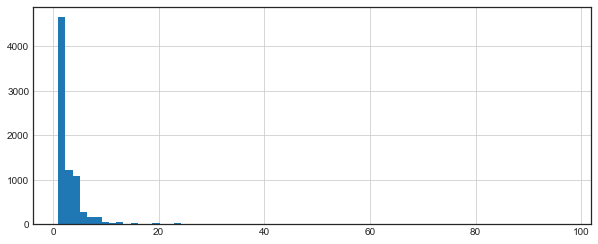

In [8]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

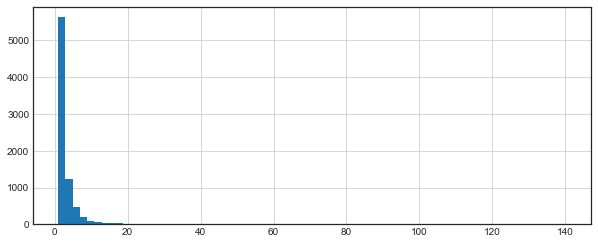

In [9]:
plt.figure(figsize=(10,4))
ratings['listen_count'].hist(bins=70)


C:\Users\marcelo.cena\AppData\Roaming\Python\Python35\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\marcelo.cena\AppData\Roaming\Python\Python35\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


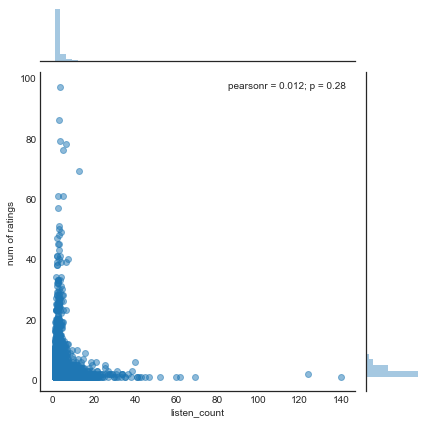

In [10]:
sns.jointplot(x='listen_count',y='num of ratings',data=ratings,alpha=0.5)

In [11]:
titles = [song_df["title"][i] for i in range(len(song_df))]
len(titles)


25000

In [12]:
summaries = [song_df["release"][i] for i in range(len(song_df))]
len(summaries)


25000

In [13]:
authors=[song_df["artist_name"][i] for i in range(len(song_df))]
len(authors)

25000

In [14]:
tags=[song_df["tag"][i] for i in range(len(song_df))]
len(tags)

25000

In [15]:
titles[4760]

'Shut Up'

In [16]:
summaries[4760]

'Hits For Kids 11'

In [17]:
authors[4760]

'Black Eyed Peas'

In [18]:
tags[4760]

'Shut Up - Hits For Kids 11'

In [19]:
discos=[song_df["release"]] 
print (discos)

[0                                         Thicker Than Water
1                                        Flamenco Para Niños
2                                                 Graduation
3                                          In Between Dreams
4                              There Is Nothing Left To Lose
5                                      Antología Audiovisual
6                                           The Fame Monster
7                              There Is Nothing Left To Lose
8                                         Musik von Harmonia
9                      Hôtel Costes 7 by Stéphane Pompougnac
10                                             If I Had Eyes
11                                                No Way Out
12                                      Original Hits - Rock
13            As/Is: Cleveland/Cincinnati_ OH - 8/03-8/04/04
14                                   Diggin' Deeper Volume 7
15                                                Incredibad
16                     

A continuación definimos un tokenizer para poder aplicar el TfidfVectorizer

In [20]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
         if token[0] not in ["\\","'","-"]:
          if len(token)>2: #eliminar palabras cortas
            filtered_tokens.append(token)
    return filtered_tokens

In [21]:
# e.g.:
from nltk.tokenize import word_tokenize
text = tags[4760]
print (text)
tokens = tokenize_only(text)
print(tokens)

Shut Up - Hits For Kids 11
['shut', 'hits', 'for', 'kids']


In [22]:
totalvocab_tokenized = []

for i in tags:
    if len(i)>1:
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

In [23]:
print('Hay en total ' + str(len(totalvocab_tokenized)) + ' tokens \n')
len(totalvocab_tokenized)
print (totalvocab_tokenized[0:100])

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_tokenized)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

Hay en total 132760 tokens 

['the', 'cove', 'thicker', 'than', 'water', 'entre', 'dos', 'aguas', 'flamenco', 'para', 'niños', 'stronger', 'graduation', 'constellations', 'between', 'dreams', 'learn', 'fly', 'there', 'nothing', 'left', 'lose', 'apuesta', 'por', 'rock', 'roll', 'antología', 'audiovisual', 'paper', 'gangsta', 'the', 'fame', 'monster', 'stacked', 'actors', 'there', 'nothing', 'left', 'lose', 'sehr', 'kosmisch', 'musik', 'von', 'harmonia', 'heaven', 'gon', 'burn', 'your', 'eyes', 'hôtel', 'costes', 'stéphane', 'pompougnac', 'let', 'sung', 'had', 'eyes', 'missing', 'you', 'featuring', 'faith', 'evans', 'album', 'version', 'way', 'out', 'love', 'shack', 'original', 'hits', 'rock', 'clarity', 'as/is', 'cleveland/cincinnati_', 'steady', 'rollin', 'man', 'diggin', 'deeper', 'volume', 'the', 'old', 'saloon', 'incredibad', 'behind', 'the', 'sea', 'live', 'chicago', 'live', 'chicago', 'champion', 'graduation', 'breakout', 'there', 'nothing', 'left', 'lose', 'ragged', 'wood']
there

Finalmente utilizamos TfidfVectorizer para representar los resumenes npumericamente y poder usar el algoritmo k-means para hacer el clustering.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,strip_accents="unicode", #max_features=400000,
                                 min_df=4, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, 
                                   ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(tags) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(25000, 13509)


C:\Users\marcelo.cena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Revisamos los términos extraidos del dataset

In [25]:
terms[200:350]

['album version blood',
 'album version born',
 'album version bows',
 'album version brand',
 'album version californication',
 'album version cassie',
 'album version cassius',
 'album version cheers',
 'album version chillout',
 'album version city',
 'album version classics',
 'album version clear',
 'album version collection',
 'album version comatose',
 'album version come',
 'album version complete',
 'album version cross',
 'album version danity',
 'album version dark',
 'album version days',
 'album version deadwing',
 'album version definition',
 'album version demon',
 'album version diamond',
 'album version digital',
 'album version dookie',
 'album version elevator',
 'album version emergency',
 'album version ends',
 'album version exception',
 'album version fair',
 'album version fallen',
 'album version family',
 'album version far',
 'album version feat',
 'album version flight',
 'album version greatest',
 'album version heart',
 'album version hits',
 'album versio

### Métrica basada en testigos

Ahora vamos a evaluar el rendimiento del clustering con k-means para distintos valores de $k$, utilizando la silhouette score, la inercia y la métrica testigo implementada.

In [26]:
from sklearn.metrics import silhouette_score
range_n_clusters=range(2,20,1)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tfidf_matrix)
    centers = clusterer.cluster_centers_
    clusters = clusterer.labels_.tolist()

    score = silhouette_score(tfidf_matrix, preds, metric='cosine')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    #print("Inertia is {})".clusterer.inertia_)
    testigos(equaltags, clusters)
    for i in range(n_clusters):
     print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))
    print("=" *40)
#plot it
#fig = plt.figure(figsize=(15, 5))
#plt.plot(range(2, 500, 10), score)
#plt.grid(True)
#plt.title('Elbow curve')

For n_clusters = 2, silhouette score is 0.005677520913216674)


NameError: name 'testigos' is not defined

Text(0.5,1,'Elbow curve')

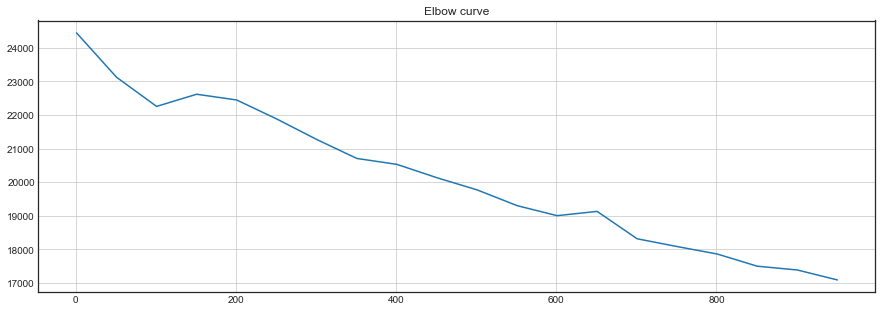

In [27]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 1000, 50):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 1000, 50), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

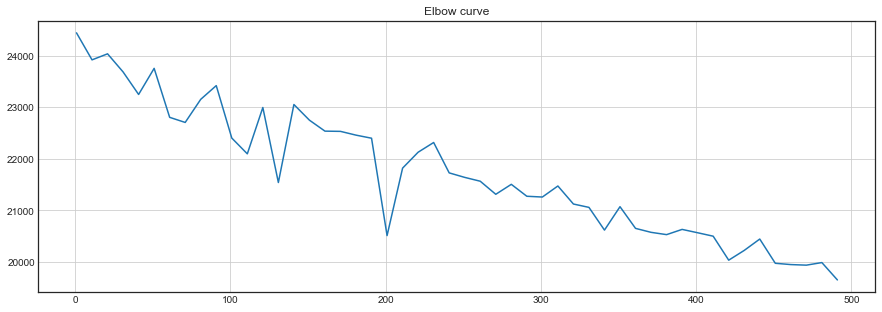

In [28]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 500, 10):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 500, 10), wcse)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5,1,'Elbow curve')

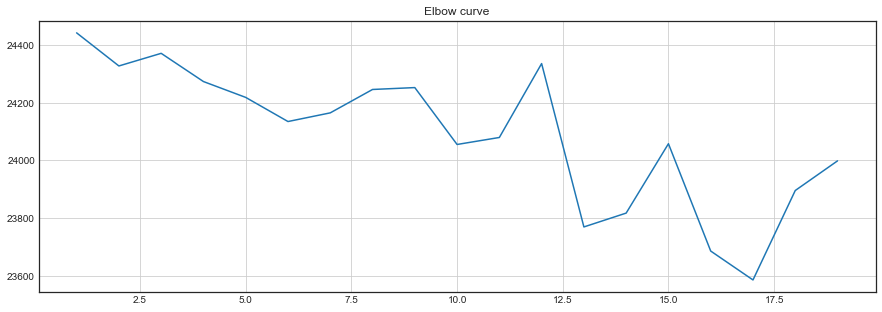

In [29]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcse = []
for k in range(1, 20, 1):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, 
                         init_size=10000, batch_size=10000, verbose=False, max_iter=1000)
    kmeans = kmeans_model.fit(tfidf_matrix) # where X is my data
    wcse.append(kmeans_model.inertia_)

#plot it
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20, 1), wcse)
plt.grid(True)
plt.title('Elbow curve')

Si bien ninguna de las métricas nos provee una forma univoca de elegir un número de clusters óptimo, despues de probar en empiricamente varios valores, para hacer un análisis mas profundo tomaremos el valor $k=9$, que es el que mejor dispersion presentaba.
Adicionalmente, se observa en todos los casos que hay un cluster dominante, enseguida analizaremos la razón, a priori podemos estimar que los nombres de las canciones tiene palabras "GANCHO" que son utilizadas para atraer sobre las mismas atención.

In [30]:
from sklearn.cluster import KMeans

num_clusters = 9

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Vemos la cantidad de elementos en cada cluster

In [31]:
# Recuento del número de elementos en cada cluster
for i in range(num_clusters):
    print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))

El cluster 0 tiene 19607 elementos
El cluster 1 tiene 335 elementos
El cluster 2 tiene 1113 elementos
El cluster 3 tiene 870 elementos
El cluster 4 tiene 77 elementos
El cluster 5 tiene 486 elementos
El cluster 6 tiene 720 elementos
El cluster 7 tiene 1713 elementos
El cluster 8 tiene 79 elementos


In [32]:
abst = { 'title': titles, 'summary': summaries, 'cluster': clusters, 'tags' :tags }
frame = pd.DataFrame(abst, columns = ['tags',"cluster"])

In [33]:
frame[1:20]

,tags,cluster
1,Entre Dos Aguas - Flamenco Para Niños,0
2,Stronger - Graduation,0
3,Constellations - In Between Dreams,0
4,Learn To Fly - There Is Nothing Left To Lose,0
5,Apuesta Por El Rock 'N' Roll - Antología Audiovisual,0
6,Paper Gangsta - The Fame Monster,0
7,Stacked Actors - There Is Nothing Left To Lose,0
8,Sehr kosmisch - Musik von Harmonia,0
9,Heaven's gonna burn your eyes - Hôtel Costes 7 by Stéphane Pompougnac,0
10,Let It Be Sung - If I Had Eyes,0


Ahora veremos los términos que determinan cada uno de los clusters para tratar de caracterizarlos

In [34]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
    print("*** Cluster %d:" % i, end='\n\n')
    
    print("WORDS /// ", end='')
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=' / ')
    print() #add whitespace
    print("=" *100) #add whitespace
    
    #print("TITLES /// ", end='')
    #for title in frame.loc[i]['title'].values.tolist():
    #    print(' %s / ' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()        
        

Top terms per cluster:

*** Cluster 0:

WORDS ///  n't /  way /  music /  world /  time /  life /  like /  edit /  radio /  black /  waking /  song /  radio /  man /  girl /  rock /  day /  edition /  dance /  just /  worlds /  vol /  night /  days /  let /  heart /  scientist /  end /  say /  home / 


*** Cluster 1:

WORDS ///  greatest /  hits /  greatest /  version /  version /  chronicle /  chronicle /  chronicle /  paradise /  city /  paradise /  city /  rearviewmirror /  album /  paradise /  rearviewmirror /  rearviewmirror /  version /  city /  rain /  original /  original /  n't /  n't /  hero /  hero /  rain /  rain /  man /  hero / 


*** Cluster 2:

WORDS ///  love /  love /  worlds /  love /  love /  lungs /  songs /  got /  somebody /  somebody /  dangerously /  dangerously /  news /  got /  somebody /  cosmic /  cosmic /  cosmic /  n't /  love /  got /  n't /  beste /  love /  beste /  story /  story /  het /  het /  uit / 


*** Cluster 3:

WORDS ///  best /  collection

A tráves de un wordcloud pueden verse mejor los términos

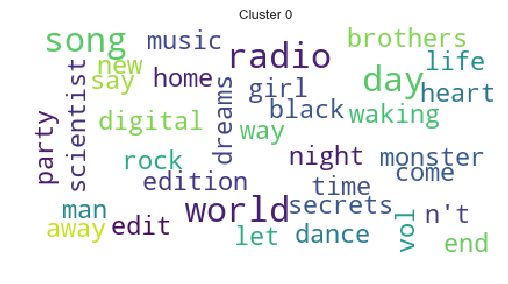

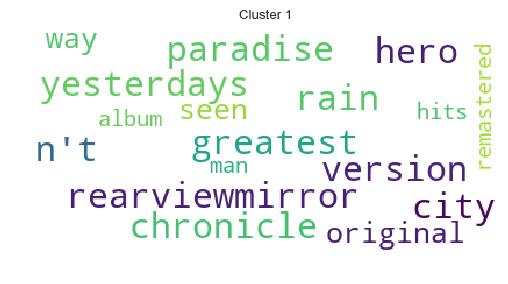

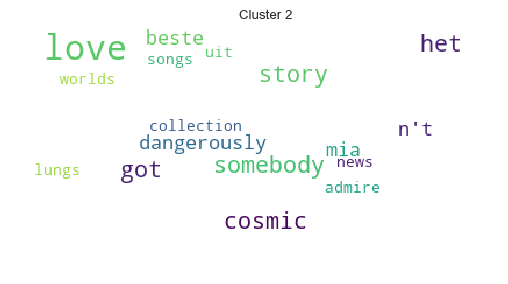

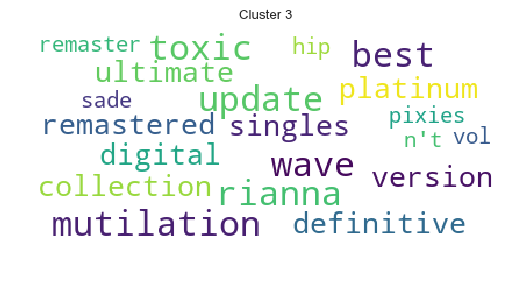

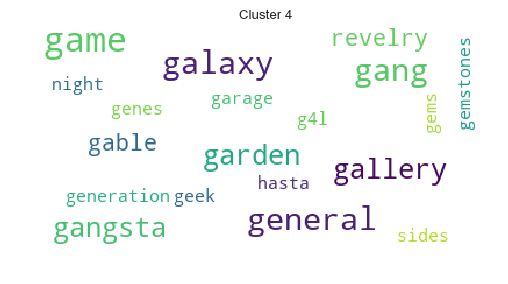

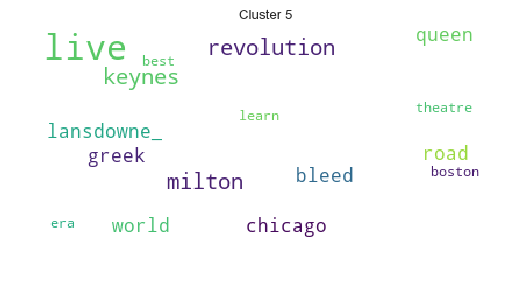

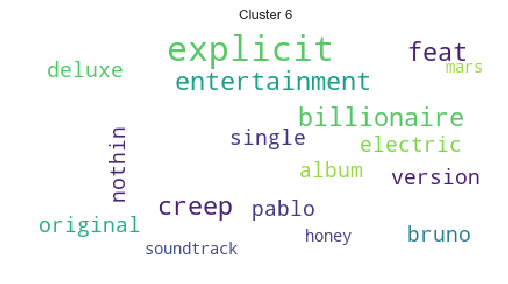

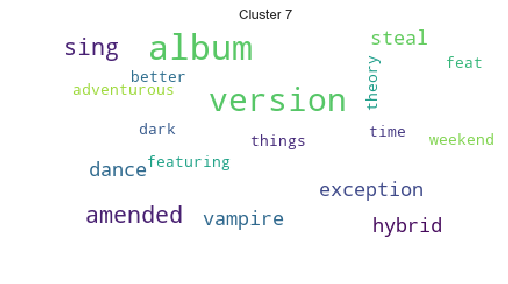

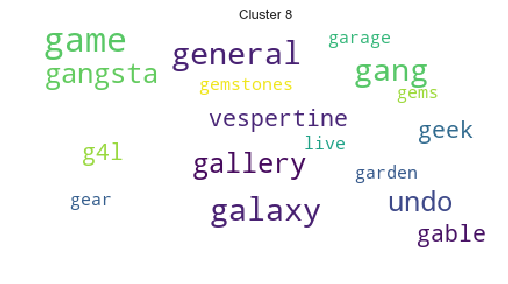

In [35]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=8              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

order_centroids = km.cluster_centers_.argsort()[:, ::-1]     
        
for i in range(num_clusters):
 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)
 plt.title("Cluster %s" %i)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


A partir de estos datos y observando los títulos de algunos de los artículos de cada cluster podemos tratar de interpretar cada uno de ellos.

## Medoids

El metodo k-means de scikit-learn no provee una forma sencilla de obtneer los objetos mas cercanos al centroide
de un cluster.
A continuación trataremos de encontrar los elementos del dataset que esten más ceca de cada uno de los clusters etc. En lo posible, implementarlos y
mostrar esos elementos, discutir la representatividad de los elementos encontrados.

In [36]:
from sklearn.metrics import pairwise_distances_argmin
closest= pairwise_distances_argmin(km.cluster_centers_, tfidf_matrix,metric="cosine")

In [37]:
closest

array([ 2096,  1990,   387,  2587,   105, 13113,  8874,  2520,    88],
      dtype=int64)

In [38]:
for x in closest:
 print("=" *60)
 print("Cluster %d" %list(closest).index(x),",",x,titles[x])
 print("-" *60)
 print(summaries[x])


Cluster 0 , 2096 One Way Ticket [Radio Edit]
------------------------------------------------------------
One Way Ticket
Cluster 1 , 1990 Lucille
------------------------------------------------------------
Greatest Hits
Cluster 2 , 387 This Unfolds
------------------------------------------------------------
There Is Love In You
Cluster 3 , 2587 Sonrisa
------------------------------------------------------------
Best Of Intuition
Cluster 4 , 105 Revelry
------------------------------------------------------------
Only By The Night
Cluster 5 , 13113 Rooster
------------------------------------------------------------
Live
Cluster 6 , 8874 Next To You   (Explicit Album Version)
------------------------------------------------------------
Next To You
Cluster 7 , 2520 Wherever You Go (Album Version)
------------------------------------------------------------
You In Reverse
Cluster 8 , 88 Undo
------------------------------------------------------------
Vespertine Live


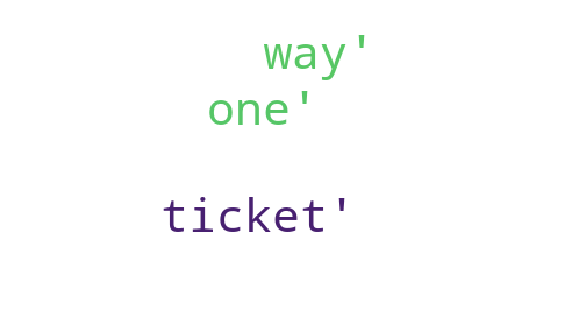

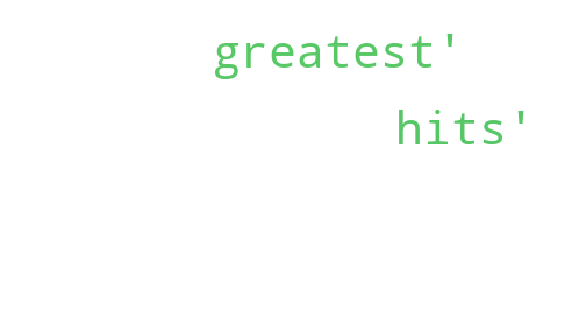

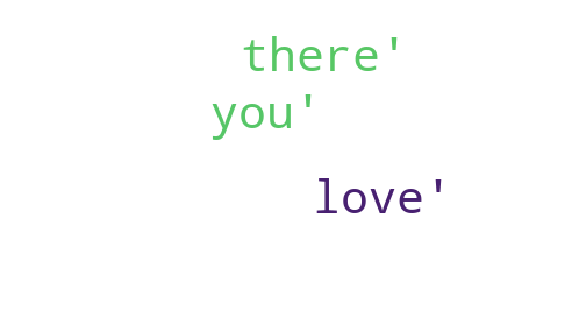

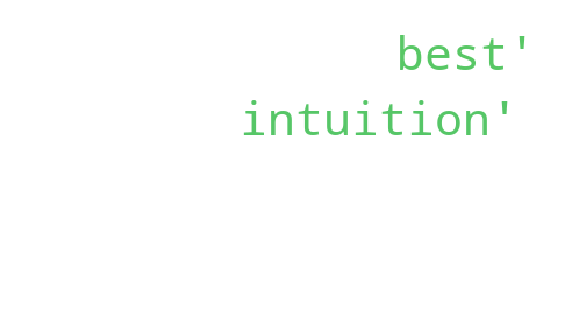

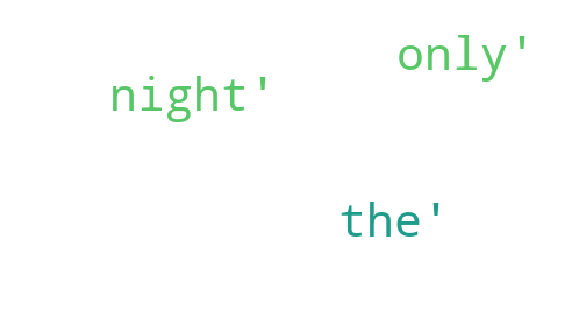

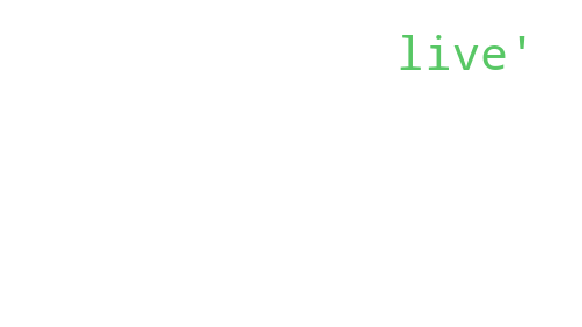

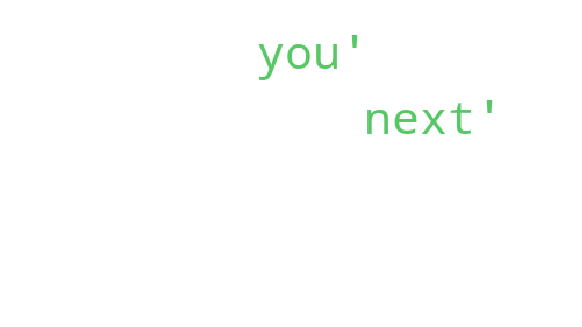

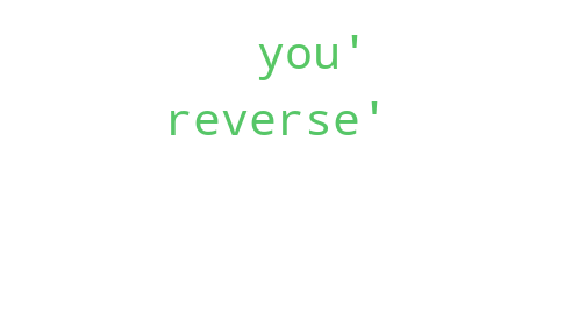

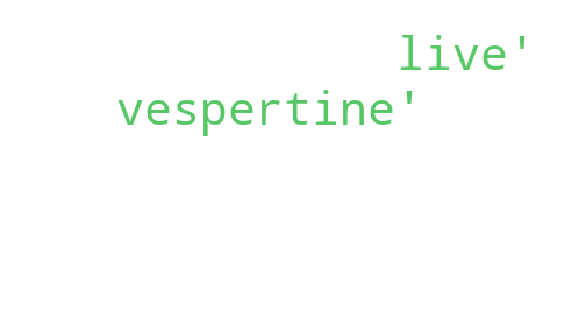

In [39]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(6.0,6.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for x in closest:
#stopwords = set(STOPWORDS)
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.figure(1)

 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


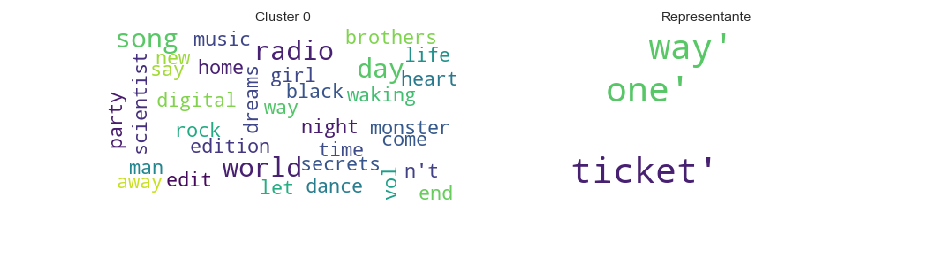

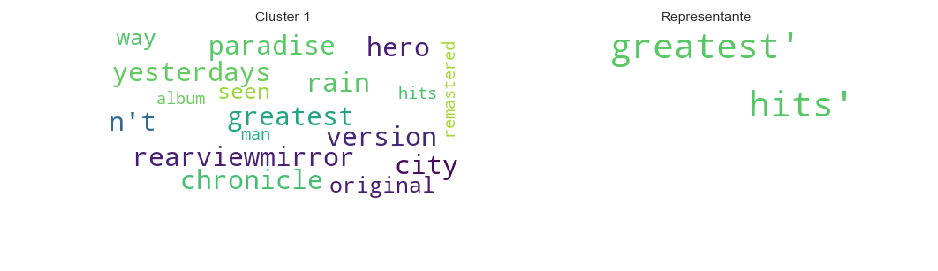

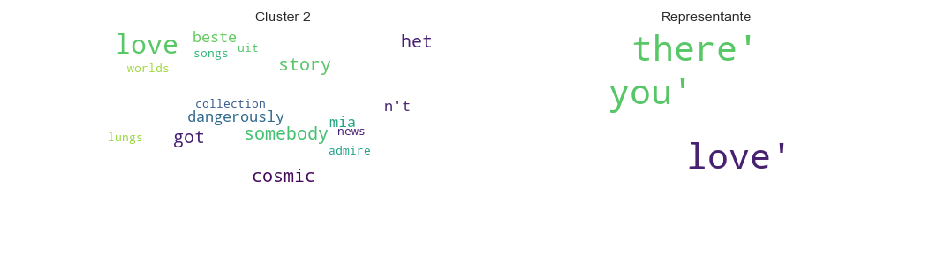

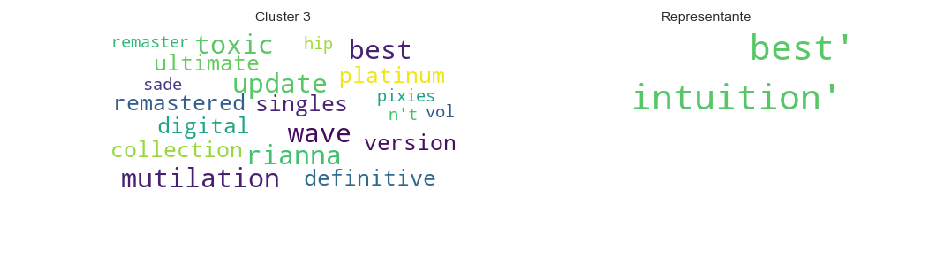

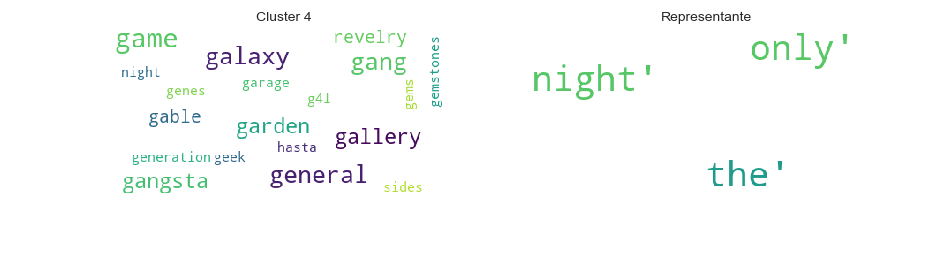

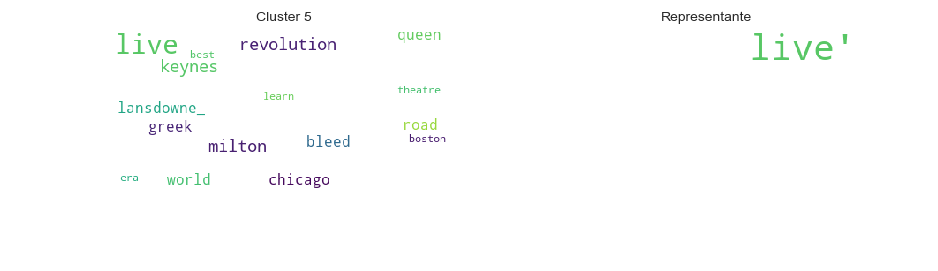

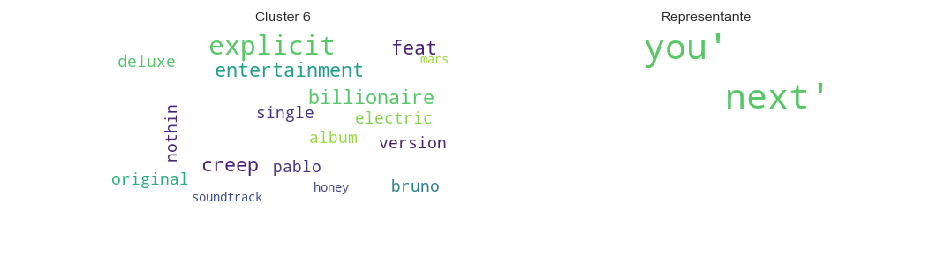

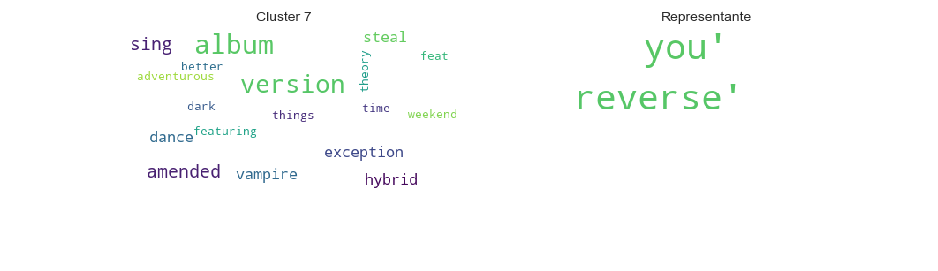

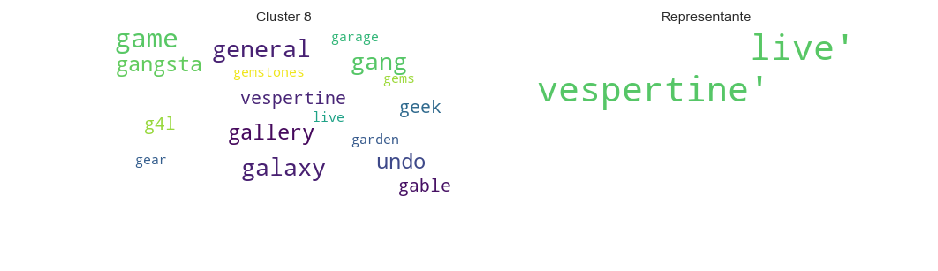

In [40]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size']=40              #10 
mpl.rcParams['figure.subplot.bottom']=.1 

for i in range(num_clusters):


 data=""
 for ind in order_centroids[i, :40]:
  data = data + " " + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])

 wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=30, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 1)
 plt.title("Cluster %s" %i,fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
    
 x=closest[i]
 data = tokenize_only(summaries[x])

 wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data))

 print(wordcloud)
 fig = plt.subplot(1, 2, 2)
 plt.title("Representante",fontsize=10)
 plt.imshow(wordcloud)
 plt.axis('off')
 plt.show()


Como podemos ver, en la mayoria de los casos las canciones mas cercanas al centroide parecen ser buenos representantes de los clusters.
Tal como se esperaba, despues de ver los dos primeros gráficos, existe un aglutinamiento de temas en uno de los clusters.
Adicionalmente, agregando el nombre del album al conjunto de entrenamiento, se dispersan un poco mas los cluster que en la notebook anterior, donde solo se analizaron los nombres de las canciones.
Otra de las limitantes que encontramos, en este caso x la disponibilidad de recursos fue el tamaño del subconjunto de datos utilizados.